#### Initial Setup

<div class="alert alert-info">
[Tip]: To execute the Python code in the code cell below, click on the cell to select it and press <kbd>Shift</kbd> + <kbd>Enter</kbd>.
</div>

In [1]:
# To run this notebook we need the following dependencies
# !pip install alhazen-py fuzzingbook pandas numpy sklearn

Example Bug Diagnosis (Tool Comparsion)
===

First, we need a faulty program. We chose an implementation of the `middle(x, y, z)` function that returns the middle number of its three arguments. For example,`middle(1, 3, 2)` should return 2 because`1 < 2` an `2 < 3`. We introduced a fault in this implementation.

In [2]:
def middle(x, y, z):
    m = z
    if y < z:
        if x < y:
            m = y
        elif x < z:
            m = y  # bug
    else:
        if x > y:
            m = y
        elif x > z:
            m = x
    return m

Next, we introduce a class to capture test runs' results efficiently. The `TestResult` is an enum with two possible values, `NO_BUG` and `BUG`. `NO_BUG` donates a passing test case and `BUG` a failing one.

In [3]:
from enum import Enum

class TestResult(Enum):
    BUG = "BUG"
    NO_BUG = "NO_BUG"

    def __repr__(self):
        return self.value

Now we implement a test function that takes the three arguments of `middle(x, y, z)` and an expected result. This test function compares the return of `middle(x, y, z)` with the desired value and returns `NO_BUG` if they match and `BUG` otherwise

In [4]:
def test(function, x, y, z, expected):
    try:
        if function(x, y, z) == expected:
            return TestResult.NO_BUG
        else:
            return TestResult.BUG
    except BaseException:
        return TestResult.BUG

def test_middle(x, y, z, expected):
    return test(middle, x, y, z, expected)

In [5]:
test_middle(3, 2, 1, expected=2)

NO_BUG

In [6]:
test_middle(3, 1, 2, expected=2)

NO_BUG

In [7]:
test_middle(2, 1, 3, expected=2)

BUG

As you can see, the result of `middle(2, 1, 3)` does not match the expected value 2. Hence, we found a failing test case.

## Automatic Bug Explanations

We can now use automatic debugging techniques to automatically find the circumstances under which the function fails. The tools `ALHAZEN` and `AVICENNA` require a set of `initial test inputs` (at least one failure-inducing input is required), a `grammar`, and the `faulty function` itself.

In [8]:
# We use the dedicated OracleResult class from Alhazen
from alhazen.oracle import OracleResult

# This will allways give us the correct solution (more info see oracle problem)
def oracle(x, y, z):
    sorted_list = sorted([x, y, z])
    return sorted_list[1]

# Automatic test function for ALHAZEN and AVICENNA 
def test_dummy(inp: str):
    x, y , z = eval(str(inp))
    truth = oracle(x,y,z)
    return OracleResult.BUG if test_middle(x,y,z, expected=truth) == TestResult.BUG else OracleResult.NO_BUG

assert test_dummy("3, 1, 4") == OracleResult.BUG
assert test_dummy("3, 2, 1") == OracleResult.NO_BUG

In [9]:
from fuzzingbook.Grammars import Grammar, is_valid_grammar

grammar: Grammar = {
    "<start>": ['<x>, <y>, <z>'],
    "<x>": ["<integer>"],
    "<y>": ["<integer>"],
    "<z>": ["<integer>"],
    "<integer>": ["<digit>", "<digit><integer>"],
    "<digit>": [str(num) for num in range(1, 10)]
}
assert is_valid_grammar(grammar)

We can now use this grammar to reproduce more test inputs.

In [10]:
from fuzzingbook.GrammarFuzzer import GrammarFuzzer

fuzzer = GrammarFuzzer(grammar)
for _ in range(10):
    inp = fuzzer.fuzz()
    print(f"middle({inp})".ljust(40), test_dummy(inp))

middle(524, 7, 673)                      BUG
middle(9, 7, 6)                          NO_BUG
middle(822, 3, 2)                        NO_BUG
middle(1, 89, 26)                        NO_BUG
middle(18, 9, 7)                         NO_BUG
middle(3958, 4, 6)                       NO_BUG
middle(2, 6, 6275)                       NO_BUG
middle(232, 393282, 47)                  NO_BUG
middle(5, 5, 1)                          NO_BUG
middle(532, 6, 9)                        NO_BUG


### ALHAZEN

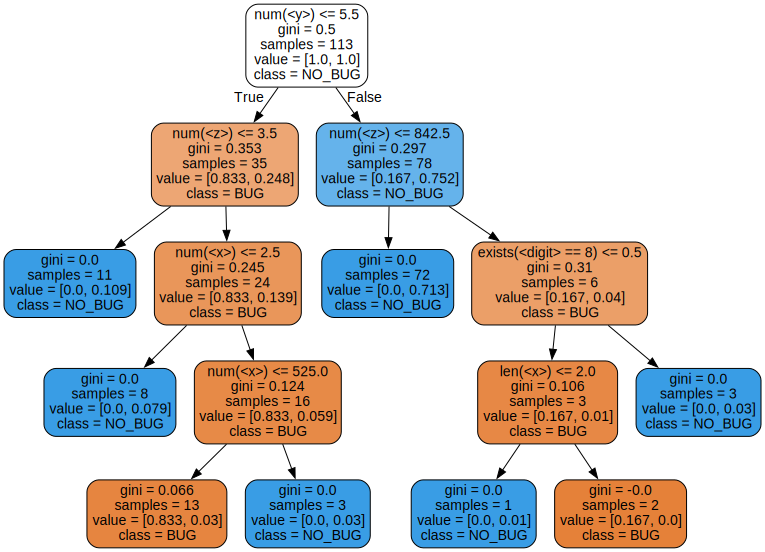

In [11]:
from alhazen import Alhazen

alhazen = Alhazen(
    grammar=grammar,
    initial_inputs=["3, 1, 4", "3, 2, 1"],
    evaluation_function=test_dummy
)

trees = alhazen.run()
alhazen.show_model()

## Avicenna

In [ ]:
# TODO

In [12]:
# TODO